In [95]:
#!pip install sympy
#!pip install control
#!pip install tbcontrol
#!pip install ipywidgets
#!pip install perlin_noise

In [96]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import control as ct
import sympy as sp

import ipywidgets as widgets
from ipywidgets import interactive

from scipy.interpolate import interp1d
from perlin_noise import PerlinNoise

In [97]:
# Paleta de cores do prof. Renato:
cp = {
    'red': (1.0, 0.349, 0.369, 1.0),
    'green': (0.541, 0.788, 0.149, 1.0),
    'blue': (0.098, 0.510, 0.769, 1.0),
    'lred': (1.0, 0.588, 0.6, 1.0),
    'lgreen': (0.722, 0.894, 0.443, 1.0),
    'lblue': (0.369, 0.706, 0.918, 1.0),
    'dred': (0.839,0.0,0.027),
    'dgreen': (0.341,0.494,0.094),
    'dblue': (0.063,0.318,0.475),
    'orange': (1.0, 0.506, 0.227, 1.0),
    'yellow': (1.0, 0.792, 0.227, 1.0),
    'pink': (1.0, 0.349, 0.611, 1.0),
    'purple': (0.416, 0.298, 0.576, 1.0),
    'turquoise': (0.098, 0.761, 0.769, 1.0),
    'brown': (0.576, 0.380, 0.298, 1.0)
}

In [98]:
#Dimensões do modelo:
n = 4 #Variáveis de estado
r = 1 #Entradas de controle
l = 1 #Entradas de distúrbio
m = 3 #Saídas

In [99]:
#Parâmetros:
Bb = 2.5 #Boca [m]
Db = 0.4 #Calado [m]
LOA = 8.4 #Comprimento fora-a-fora do barco [m]
Hb = 1.7 #Altura do barco [m]
Me = 10.0 #Massa do eixo do giroscópio [kg]
Md = 160.0 #Massa do disco do giroscópio [kg]
le = 0.5 #Comprimento do eixo do giroscópio [m]
re = 0.09 #Raio do eixo do giroscópio [m]
rd = 0.230 #Raio do disco do giroscópio [m]
ed = 0.150 #Espessura do disco do giroscópio [m]
g = 9.81 #Aceleração da gravidade [m/s²]
rho_w = 997.0 #Massa específica da água a 25°C [kg/m³]
wf_base = 1.40071 #freq. de exitação das ondas [rad/s]
A0_base = 2.5 #Altura das ondas [m]
Cg = 500.0 #Momento de restituição do giroscópio [N.m]
Bg = 250.0 #Coef. de dissipação por atrito do giroscópio [N.m.s]

c2 = 0.006 #Coef. adim. da dissipação por irradiação de ondas
c3 = 0.149 #Coef. adim. de massa adicional da embarcação

Representação em Espaço de Estados do Modelo Linearizado:

In [100]:
Omega = sp.symbols('Ω')

#Componentes da matriz A:
a_31 = - g*LOA*(Bb**2 - 6*Db**2)/(Db*((Bb**2)*(LOA+12*c3) + LOA*Hb**2))
a_33 = - 12*np.sqrt(2)*(g**2)*((Bb/g)**(3/2))*c2/((Bb**2)*(LOA+12*c3)+LOA*Hb**2)
a_34 = - 6*Omega*Md*(rd**2)/(Bb*Db*((Bb**2)*(LOA+12*c3)+LOA*Hb**2)*rho_w)
a_42 = -12*Cg/((ed**2)*(Md-Me)+3*Md*(rd**2)+Me*((le**2)+3*(re**2)))
a_43 = Omega*(-1 + (12*Md*rd**2)/((ed**2)*(Md-Me)+3*Md*rd**2 + Me*(le**2 + 3*re**2)))
a_44 = -12*Bg/((ed**2)*(Md-Me)+3*Md*rd**2 + Me*(le**2 + 3*re**2))

#Matriz A:
A = sp.Matrix([[0,0,1,0],[0,0,0,1],[a_31,0,a_33,a_34],[0,a_42,a_43,a_44]])

#Componentes da matriz B:
I_Gy = (1/12)*Me*(3*re**2 + le**2 - ed**2) + (1/12)*Md*(3*rd**2 + ed**2) #Momento de Inércia do Giroscópio em relação ao eixo y móvel

#Matriz B:
B = sp.Matrix([[0],[0],[0],[(1/I_Gy)]])

#Componentes da matriz E:
e_3 = g*LOA*(Bb**2 - 6*Db**2)/(Db*((Bb**2)*(LOA+12*c3)+LOA*Hb**2))

#Matriz E:
E = sp.Matrix([[0],[0],[e_3],[0]])

#Matriz C:
C = sp.Matrix([[1,0,0,0],[0,1,0,0],[0,0,0,1]])

#Matriz D:
D = sp.Matrix([[0],[0],[0]])


In [101]:
An = sp.lambdify((Omega), A)
Bn = sp.lambdify((),B)
Cn = sp.lambdify((),C)
En = sp.lambdify((),E)

In [102]:
E

Matrix([
[               0],
[               0],
[12.3909097110891],
[               0]])

In [103]:
#Espaço de Estados com Ω = 8000 rpm:
mod_boat1 = ct.ss(An(8000*np.pi/30),B,C,D)
mod_boat1


<LinearIOSystem:sys[27]:['u[0]']->['y[0]', 'y[1]', 'y[2]']>

Agora, com o modelo SLIT estabelecido, vamos analisar a controlabilidade e a observabilidade do sistema:

In [104]:
ct.ctrb(An(8000*np.pi/30),B)

array([[ 0.00000000e+00,  0.00000000e+00, -1.84774660e-01,
         1.75946504e+01],
       [ 0.00000000e+00,  3.80831482e-01, -3.62581544e+01,
         3.03537747e+03],
       [ 0.00000000e+00, -1.84774660e-01,  1.75946504e+01,
        -1.47068976e+03],
       [ 3.80831482e-01, -3.62581544e+01,  3.03537747e+03,
        -2.49315277e+05]])

In [105]:
np.linalg.matrix_rank(ct.ctrb(An(8000*np.pi/30),B))

4

In [106]:
ct.obsv(An(8000*np.pi/30),C)

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 0.00000000e+00, -1.90415741e+02,  1.86263576e+03,
        -9.52078705e+01],
       [-1.23909097e+01,  0.00000000e+00, -1.43334663e-02,
        -4.85187463e-01],
       [ 0.00000000e+00, -1.90415741e+02,  1.86263576e+03,
        -9.52078705e+01],
       [-2.30797515e+04,  1.81290772e+04, -1.77364282e+05,
         7.97039535e+03],
       [ 1.77604687e-01,  9.23873302e+01, -9.16118223e+02,
         4.62006195e+01],
       [-2.30797515e+04,  1.81290772e+04, -1.77364282e+05,
         7.97039535e+03],
       [ 2.19770481e+06, -1.51768874e+06,  1.48254059e+07,
      

In [107]:
np.linalg.matrix_rank(ct.obsv(An(8000*np.pi/30),C))

4

Síntese por alocação de Polos:

In [108]:
#Polos da Matriz A original:
np.linalg.eig(An(8000*np.pi/30))

(array([-81.8603462 +0.j        , -12.41365337+0.j        ,
         -0.47410221+1.44812641j,  -0.47410221-1.44812641j]),
 array([[ 7.22763174e-05+0.j        , -2.90601192e-03+0.j        ,
          3.78682560e-02+0.00487182j,  3.78682560e-02-0.00487182j],
        [ 1.22148016e-02+0.j        , -8.02437453e-02+0.j        ,
          1.70298938e-01+0.52017136j,  1.70298938e-01-0.52017136j],
        [-5.91656437e-03+0.j        ,  3.60742247e-02+0.j        ,
         -2.50084288e-02+0.05252828j, -2.50084288e-02-0.05252828j],
        [-9.99907890e-01+0.j        ,  9.96118039e-01+0.j        ,
         -8.34012980e-01+0.j        , -8.34012980e-01-0.j        ]]))

In [109]:
#Polinômio caracterísco da Matriz A:
p = A.charpoly()
p

PurePoly(1.0*lambda**4 + 95.2222039835811*lambda**3 + (0.00128765730763755*Ω**2 + 204.171309547808)*lambda**2 + 1182.44144496914*lambda + 2359.42425472976, lambda, domain='RR[Ω]')

In [110]:
a = p.all_coeffs()
a

[1.00000000000000,
 95.2222039835811,
 0.00128765730763755*Ω**2 + 204.171309547808,
 1182.44144496914,
 2359.42425472976]

In [111]:
#Matriz Q:
Q = sp.Matrix([[B, A*B, A*A*B, A*A*A*B]])
Q

Matrix([
[                0,                       0,                      -0.000220558504262905*Ω,                                                                        0.0210020668832359*Ω],
[                0,       0.380831482069184,                            -36.2581544337529,                                                3379.54536365736 - 0.000490380440864823*Ω**2],
[                0, -0.000220558504262905*Ω,                         0.0210020668832359*Ω, -0.000220558504262905*Ω*(-0.00128765730763755*Ω**2 - 12.3907042628334) - 1.95756425338401*Ω],
[0.380831482069184,       -36.2581544337529, 3379.54536365736 - 0.000490380440864823*Ω**2,                                                  0.0933831838876613*Ω**2 - 314855.194045369]])

In [112]:
#Matriz Toeplitz W:
W = sp.Matrix([[1, a[1],a[2],a[3]],[0,1,a[1],a[2]],[0,0,1,a[1]],[0,0,0,1]])
W

Matrix([
[1, 95.2222039835811, 0.00128765730763755*Ω**2 + 204.171309547808,                            1182.44144496914],
[0,                1,                            95.2222039835811, 0.00128765730763755*Ω**2 + 204.171309547808],
[0,                0,                                           1,                            95.2222039835811],
[0,                0,                                           0,                                           1]])

In [113]:
# Polos desejados para alocação em MF
#Pretende-se manter R
λ, ζ, ω_n, r, R = sp.symbols('λ ζ ω_n r R')
p_ = sp.PurePoly((λ + r) * (λ + R) * ((λ + ζ*ω_n)**2 + ω_n**2 * (1 - ζ**2)), λ)
a_ = p_.all_coeffs()
a_

[1,
 R + r + 2*ζ*ω_n,
 R*r + 2*R*ζ*ω_n + 2*r*ζ*ω_n + ω_n**2,
 2*R*r*ζ*ω_n + R*ω_n**2 + r*ω_n**2,
 R*r*ω_n**2]

In [114]:
k = ((Q*W).inv()).T * (sp.Matrix(a_[1:]) - sp.Matrix(a[1:]))
kn = sp.lambdify((Omega, R, ζ, ω_n, r), k)
k

Matrix([
[5.24474320431022*(R*r*ω_n**2 - 2359.42425472976)/Ω + 56179.69596093*(R + r + 2*ζ*ω_n - 95.2222039835811)/Ω - 4533.9444214221*(2*R*r*ζ*ω_n + R*ω_n**2 + r*ω_n**2 - 1182.44144496914)/Ω + 7.09242726415548e-11*(R*r + 2*R*ζ*ω_n + 2*r*ζ*ω_n - 0.00128765730763755*Ω**2 + ω_n**2 - 204.171309547808)/Ω],
[                                                                                                     0.211916105803251*R*r*ω_n**2 - 1.6209231829272e-14*R*r - 3.2418463658544e-14*R*ζ*ω_n - 3.2418463658544e-14*r*ζ*ω_n + 2.08719358161533e-17*Ω**2 - 1.6209231829272e-14*ω_n**2 - 500.000000000066],
[                                                                             365.908922519637*(R*r*ω_n**2 - 2359.42425472976)/Ω + 64.9871395023673*(R + r + 2*ζ*ω_n - 95.2222039835811)/Ω - 4533.94442142213*(R*r + 2*R*ζ*ω_n + 2*r*ζ*ω_n - 0.00128765730763755*Ω**2 + ω_n**2 - 204.171309547808)/Ω],
[                                                                                                         

In [115]:
# Polos desejados para alocação em MF com a função control.place():
kT = ct.place(An(8000*np.pi/30), Bn(), [-1.5+1.5j, -1.5-1.5j, -12.4, -81.8])
kT

array([[-1.22168330e+04,  4.67278350e+02, -8.40944130e+01,
         5.19336271e+00]])

Análise do sistema em malha fechada:

In [116]:
#Matriz de Estados em MF Simbólica:
A_c = A - B*k.T
A_cn = sp.lambdify((Omega, R, ζ, ω_n, r), A_c)
A_c


Matrix([
[                                                                                                                                                                                                                                                                                                      0,                                                                                                                                                                                                        0,                                                                                                                                                                                                                                          1,                                               0],
[                                                                                                                                                                                                            

In [117]:
#Matriz de Estados em MF a partir do ct.place() para 8000 rpm:

A_c1 = An(8000*np.pi/30) - B*kT
A_cn1 = An(8000*np.pi/30) - Bn()*kT
A_c1

Matrix([
[                0,                 0,                 1.0,                  0],
[                0,                 0,                   0,                1.0],
[-12.3909097110891,                 0, -0.0143334662850031, -0.485187462559072],
[ 4652.55460065872, -368.370047593448,    1894.66156106392,   -97.185666533715]])

In [118]:
np.linalg.eig(A_cn1)

(array([-81.8+0.j , -12.4+0.j ,  -1.5+1.5j,  -1.5-1.5j]),
 array([[ 7.23827996e-05+0.j        ,  2.91191608e-03+0.j        ,
          3.12725630e-02+0.01132262j,  3.12725630e-02-0.01132262j],
        [ 1.22238112e-02+0.j        ,  8.03314305e-02+0.j        ,
          3.00592753e-01+0.30059275j,  3.00592753e-01-0.30059275j],
        [-5.92091301e-03+0.j        , -3.61077594e-02+0.j        ,
         -6.38927799e-02+0.02992491j, -6.38927799e-02-0.02992491j],
        [-9.99907754e-01+0.j        , -9.96109739e-01+0.j        ,
         -9.01778260e-01+0.j        , -9.01778260e-01-0.j        ]]))

In [119]:
(A_c1).charpoly()

PurePoly(1.0*lambda**4 + 97.2*lambda**3 + 1301.42*lambda**2 + 3466.86000000001*lambda + 4564.44000000005, lambda, domain='RR')

Simulação do Sistema Controlado:

(array([-81.8+0.j , -12.4+0.j ,  -1.5+1.5j,  -1.5-1.5j]),
 array([-84.30274785+0.j, -12.48486867+0.j,  -1.05926467+0.j]))

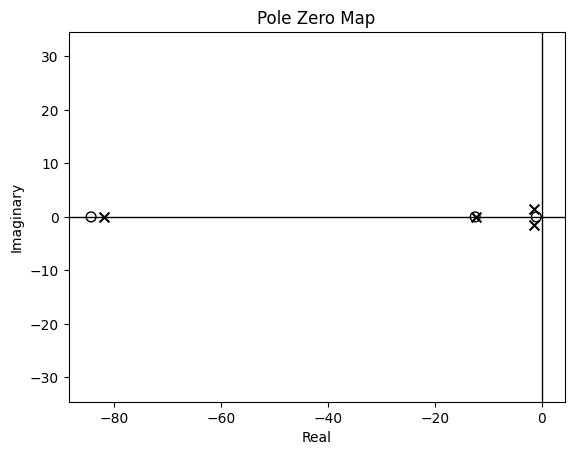

In [120]:
mod_boat_U = ct.ss(A_cn1, B, -kT, np.array([[0]]))
ct.pzmap(mod_boat_U)

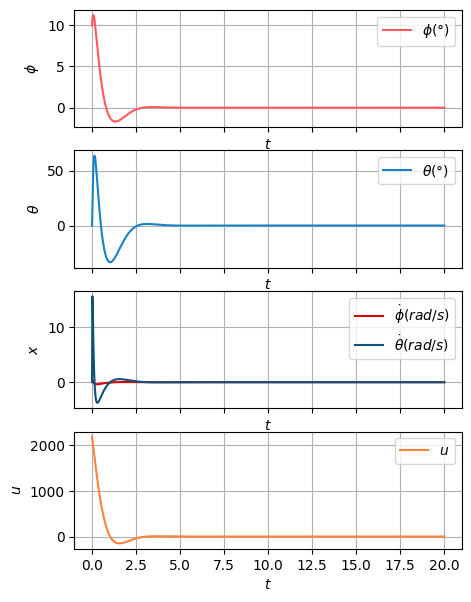

In [121]:
ts = np.linspace(0, 20, 1001)
w = np.linspace(0.1, 0.1, 1001)
x0 = [(10*np.pi/180), 0.0, 0.6, 0.0]
t, u, x = ct.forced_response(mod_boat_U, U=0, T=ts, X0=x0, return_x=True)


fig, (roll, nut, vel, control_input) = plt.subplots(
    4, 1, figsize=(5, 7), sharex=True)

roll.plot(t, (x[0, :]*180/np.pi), color=cp['red'], label=r'$\phi (°)$',)
roll.set_ylabel(r'$\phi$')
roll.set_xlabel(r'$t$')
roll.legend()
roll.grid()

nut.plot(t, (x[1, :]*180/np.pi), color=cp['blue'], label=r'$\theta (°)$',)
nut.set_ylabel(r'$\theta$')
nut.set_xlabel(r'$t$')
nut.legend()
nut.grid()

vel.plot(t, x[2, :], color=cp['dred'], label=r'$\dot \phi (rad/s)$',)
vel.plot(t, x[3, :], color=cp['dblue'], label=r'$\dot \theta (rad/s)$',)
vel.set_ylabel(r'$x$')
vel.set_xlabel(r'$t$')
vel.legend()
vel.grid()

control_input.plot(t, u, color=cp['orange'], label=r'$u$')
control_input.set_ylabel(r'$u$')
control_input.set_xlabel(r'$t$')
control_input.legend()
control_input.grid()

In [122]:
#Parâmetros para inserção de perturbações:
'''
Freqadm = np.sqrt(Bb/(2*g))
lda = g*2*np.pi/wf
k0 = 2*np.pi/lda 
aphm0 = A0/lda
'''

'\nFreqadm = np.sqrt(Bb/(2*g))\nlda = g*2*np.pi/wf\nk0 = 2*np.pi/lda \naphm0 = A0/lda\n'

In [123]:
mod_boat_E = ct.ss(A_cn1, E, C, np.array([[0],[0],[0]]))

In [124]:
'''
ts = np.linspace(0, 20, 1001)
w = np.linspace(0.1, 0.1, 1001)
x0 = [(15.0*np.pi/180), 0.0, 0.0, 0.0]
t, y, x = ct.forced_response(mod_boat_E, U = aphm0*np.sin(wf*ts), T=ts, X0=x0, return_x=True)

fig, (state, control_input) = plt.subplots(
    2, 1, figsize=(5, 7), sharex=True)

state.plot(t, (x[0, :]*180/np.pi), color=cp['red'], label=r'$\phi (°)$')
#state.plot(t, (x[1, :]*180/np.pi), color=cp['blue'], label=r'$\theta (°)$')
#state.plot(t, x[2, :], color=cp['red'], label=r'$\dot\phi$')
#state.plot(t, x[3, :], color=cp['red'], label=r'$\dot\theta$')
# state.plot(t, x[:, 2], color='black', label=r'$x_3$')
state.set_ylabel(r'$x$')
state.set_xlabel(r'$t$')
state.legend()

control_input.plot(t, y[2,:], color=cp['orange'], label=r'$\dot \theta$')
control_input.set_ylabel(r'$y$')
control_input.set_xlabel(r'$t$')
control_input.legend()
'''

"\nts = np.linspace(0, 20, 1001)\nw = np.linspace(0.1, 0.1, 1001)\nx0 = [(15.0*np.pi/180), 0.0, 0.0, 0.0]\nt, y, x = ct.forced_response(mod_boat_E, U = aphm0*np.sin(wf*ts), T=ts, X0=x0, return_x=True)\n\nfig, (state, control_input) = plt.subplots(\n    2, 1, figsize=(5, 7), sharex=True)\n\nstate.plot(t, (x[0, :]*180/np.pi), color=cp['red'], label=r'$\\phi (°)$')\n#state.plot(t, (x[1, :]*180/np.pi), color=cp['blue'], label=r'$\theta (°)$')\n#state.plot(t, x[2, :], color=cp['red'], label=r'$\\dot\\phi$')\n#state.plot(t, x[3, :], color=cp['red'], label=r'$\\dot\theta$')\n# state.plot(t, x[:, 2], color='black', label=r'$x_3$')\nstate.set_ylabel(r'$x$')\nstate.set_xlabel(r'$t$')\nstate.legend()\n\ncontrol_input.plot(t, y[2,:], color=cp['orange'], label=r'$\\dot \theta$')\ncontrol_input.set_ylabel(r'$y$')\ncontrol_input.set_xlabel(r'$t$')\ncontrol_input.legend()\n"

In [125]:
mod_boat_passive = ct.ss(An(8000*np.pi/30),E,C,D)

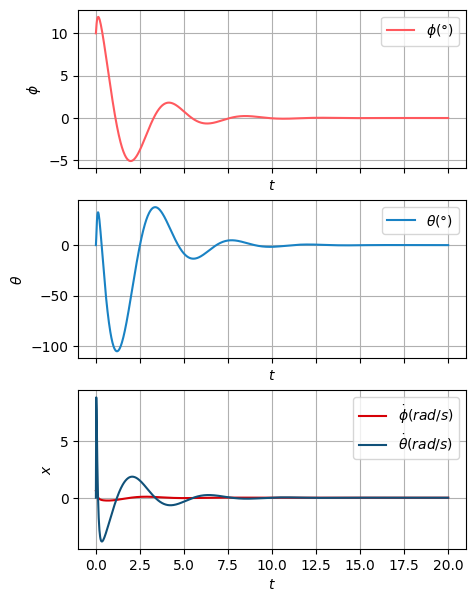

In [126]:
ts = np.linspace(0, 20, 1001)
w = np.linspace(0.1, 0.1, 1001)
x0 = [(10.0*np.pi/180), 0.0, 0.6, 0.0]
t, y, x = ct.forced_response(mod_boat_passive, U = 0, T=ts, X0=x0, return_x=True)

fig, (roll, nut, vel) = plt.subplots(
    3, 1, figsize=(5, 7), sharex=True)

roll.plot(t, (x[0, :]*180/np.pi), color=cp['red'], label=r'$\phi (°)$',)
roll.set_ylabel(r'$\phi$')
roll.set_xlabel(r'$t$')
roll.legend()
roll.grid()

nut.plot(t, (x[1, :]*180/np.pi), color=cp['blue'], label=r'$\theta (°)$',)
nut.set_ylabel(r'$\theta$')
nut.set_xlabel(r'$t$')
nut.legend()
nut.grid()

vel.plot(t, x[2, :], color=cp['dred'], label=r'$\dot \phi (rad/s)$',)
vel.plot(t, x[3, :], color=cp['dblue'], label=r'$\dot \theta (rad/s)$',)
vel.set_ylabel(r'$x$')
vel.set_xlabel(r'$t$')
vel.legend()
vel.grid()


In [127]:
mod_boat_OFF = ct.ss(An(0*np.pi/30),E,C,D)

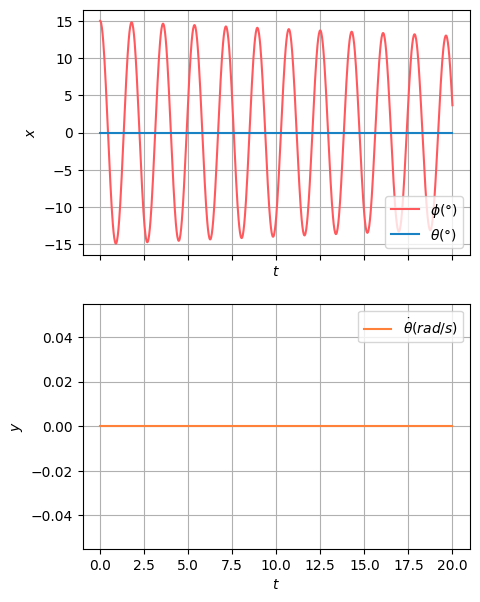

In [128]:
ts = np.linspace(0, 20, 1001)
w = np.linspace(0.1, 0.1, 1001)
x0 = [(15.0*np.pi/180), 0.0, 0.0, 0.0]
t, y, x = ct.forced_response(mod_boat_OFF, U = 0, T=ts, X0=x0, return_x=True)

fig, (state, control_input) = plt.subplots(
    2, 1, figsize=(5, 7), sharex=True)

state.plot(t, (x[0, :]*180/np.pi), color=cp['red'], label=r'$\phi (°)$',)
state.plot(t, (x[1, :]*180/np.pi), color=cp['blue'], label=r'$\theta (°)$')
#state.plot(t, x[2, :], color=cp['red'], label=r'$\dot\phi$')
#state.plot(t, x[3, :], color=cp['red'], label=r'$\dot\theta$')
# state.plot(t, x[:, 2], color='black', label=r'$x_3$')
state.set_ylabel(r'$x$')
state.set_xlabel(r'$t$')
state.legend()
state.grid()

control_input.plot(t, y[2,:], color=cp['orange'], label=r'$\dot \theta (rad/s) $')
control_input.set_ylabel(r'$y$')
control_input.set_xlabel(r'$t$')
control_input.legend()
control_input.grid()

Síntese do Regulador LQR

In [129]:
#Síntese do LQR:
Q = 1000*np.diag([50000, 10, 1000, 1])
R = 1

# Matriz de ganhos de controle
K_lq, P_lq, poles_lq = ct.lqr(mod_boat1, Q, R)
K_lq

# Polos do sistema em malha fechada
poles_lq


array([-82.73249192+0.j        , -12.40574438+0.j        ,
        -0.80995285+1.29935889j,  -0.80995285-1.29935889j])

In [130]:
#MF do LQR:
boat_CLLQ_SS = ct.ss(An(8000*np.pi/30) - np.dot(B, K_lq), E, -K_lq, 0)
boat_CLLQ_SS

<LinearIOSystem:sys[32]:['u[0]']->['y[0]']>

(array([-82.73249192+0.j        , -12.40574438+0.j        ,
         -0.80995285+1.29935889j,  -0.80995285-1.29935889j]),
 array([-70.71100518+0.j,  -2.06665409+0.j, -12.53286589+0.j]))

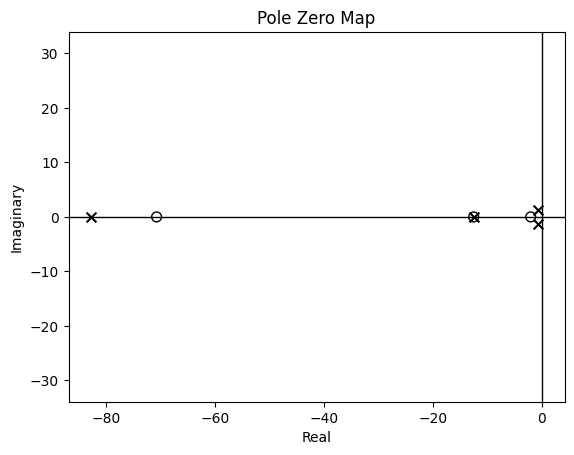

In [131]:
ct.pzmap(boat_CLLQ_SS)

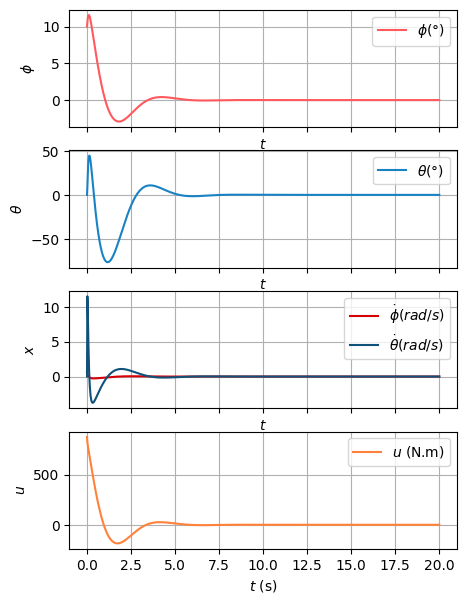

In [132]:
ts = np.linspace(0, 20, 1001)
w = np.linspace(0.1, 0.1, 1001)
x0 = [(10.0*np.pi/180), 0.0, 0.6, 0.0]
t, u, x = ct.forced_response(boat_CLLQ_SS, U=0, T=ts, X0=x0, return_x=True)

fig, (roll, nut, vel, control_input) = plt.subplots(
    4, 1, figsize=(5, 7), sharex=True)

roll.plot(t, (x[0, :]*180/np.pi), color=cp['red'], label=r'$\phi (°)$',)
roll.set_ylabel(r'$\phi$')
roll.set_xlabel(r'$t$')
roll.legend()
roll.grid()

nut.plot(t, (x[1, :]*180/np.pi), color=cp['blue'], label=r'$\theta (°)$',)
nut.set_ylabel(r'$\theta$')
nut.set_xlabel(r'$t$')
nut.legend()
nut.grid()

vel.plot(t, x[2, :], color=cp['dred'], label=r'$\dot \phi (rad/s)$',)
vel.plot(t, x[3, :], color=cp['dblue'], label=r'$\dot \theta (rad/s)$',)
vel.set_ylabel(r'$x$')
vel.set_xlabel(r'$t$')
vel.legend()
vel.grid()

control_input.plot(t, u, color=cp['orange'], label=r'$u$ (N.m)')
control_input.set_ylabel(r'$u$')
control_input.set_xlabel(r'$t$ (s)')
control_input.legend()
control_input.grid()

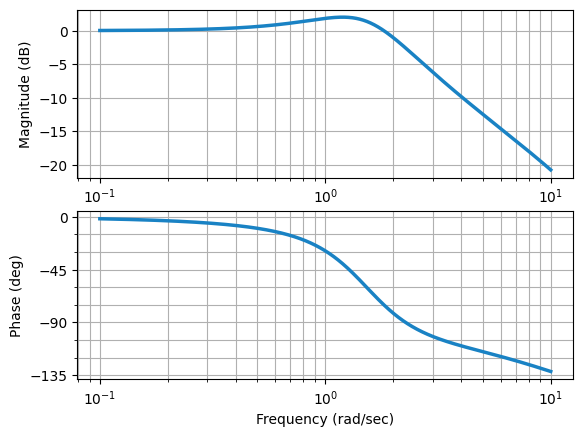

In [133]:
# Diagrama de Bode para função de sensibilidade
bode_saida = ct.ss(An(8000*np.pi/30) - np.dot(B, K_lq), E, np.array([1,0,0,0]), 0)
plt.figure()
_, _, _ = ct.bode_plot(bode_saida
    , color=cp['blue'], linewidth=2.5, dB=True, omega_limits=(1e-1, 10), initial_phase = 0)

Observador de Luenberger:

In [134]:
#Posicionaremos os polos do Observador com parte real 2x mais negativa:

obs_poles = np.array([-81.8 , -2 + 0.5j , -2 - 0.5j , -12.4 + 0.j])
L = ct.place(An(8000*np.pi/30).T , Cn().T, obs_poles).T

A_obs = An(8000*np.pi/30) - np.dot(L,C)

Resposta em Malha Fechada do Regulador LQR + Observador de Luenberger:

In [135]:
#Construção da Matriz estendida:
Aa = np.block([[An(8000*np.pi/30) - np.dot(Bn(),K_lq), np.dot(Bn(),K_lq)],[np.zeros((n,n)), A_obs]])
Aa

array([[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
       [-12.3909097110891, 0.0, -0.0143334662850031,
        -0.48518746255907236, 0.0, 0.0, 0.0, 0.0],
       [1409.9998750411016, -194.1867158461235, 2009.2299403375177,
        -96.74380854329667, -1409.9998750411016, 3.7709748115314907,
        -146.59417920184382, 1.5359380260005588],
       [0.0, 0.0, 0.0, 0.0, -2.42509061397961, -2.02417943167108,
        1.00000000000000, -0.0190499570315158],
       [0.0, 0.0, 0.0, 0.0, -2.07549366480058, -11.9611146644826, 0,
        0.0146205666516814],
       [0.0, 0.0, 0.0, 0.0, -0.399167901141027, 0.537707815329625,
        -0.0143334662850031, -0.0877305862951243],
       [0.0, 0.0, 0.0, 0.0, 3.97925786353413, 19.4457629573530,
        1862.63576113567, -83.7994612552528]], dtype=object)

In [136]:
Ba = np.block([[Bn()],[np.zeros((n,1))]])
Ba

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.38083148],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]])

In [137]:
Ea = np.block([[En()],[np.zeros((n,1))]])
Ea

array([[ 0.        ],
       [ 0.        ],
       [12.39090971],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

In [138]:
Ka = np.block([[K_lq, np.zeros((1,n))]])
Ka

array([[-3702.42467188,     9.90195136,  -384.93188222,     4.03311727,
            0.        ,     0.        ,     0.        ,     0.        ]])

In [139]:
boat_LQ_OBS_SS = ct.ss(Aa, Ea, -Ka, 0)
boat_LQ_OBS_SS

<LinearIOSystem:sys[35]:['u[0]']->['y[0]']>

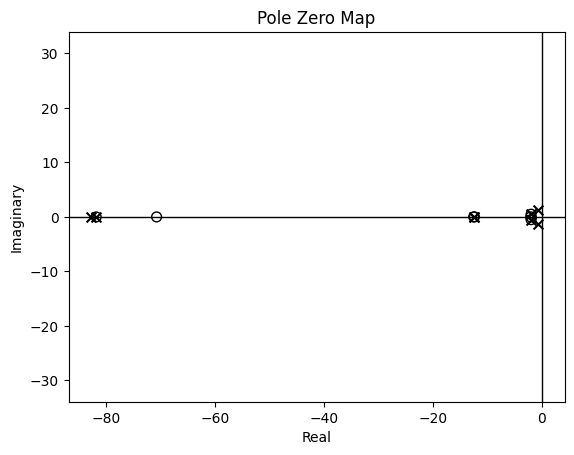

In [141]:
#Polos e Zeros:
ct.pzmap(boat_LQ_OBS_SS)
plt.draw()

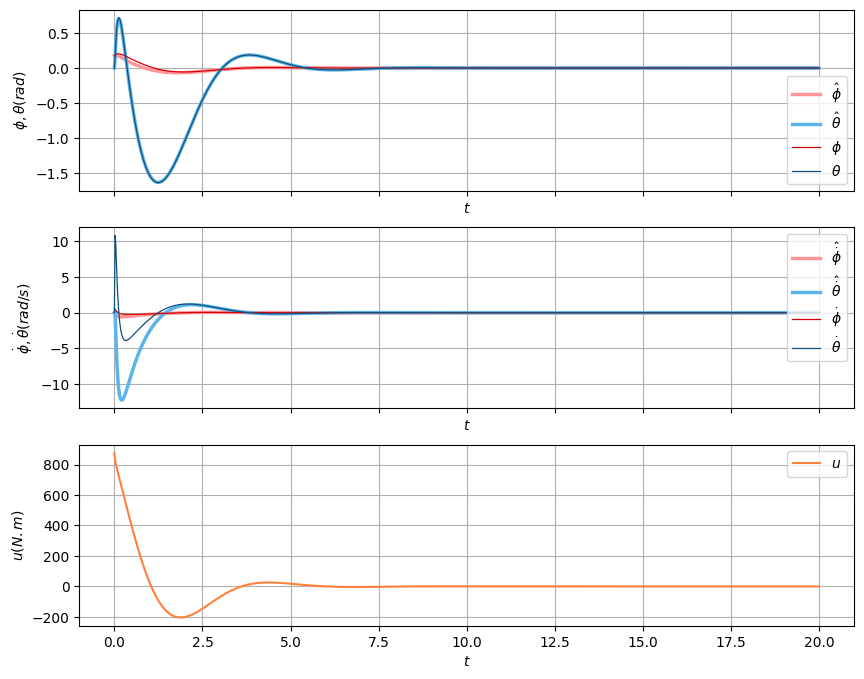

In [143]:
#Simulação Numérica:
ts = np.linspace(0, 20, 1001)
w = np.linspace(0.1, 0.1, 1001)
x0 = [(10.0*np.pi/180), 0.0, 0.6, 0.0, 0, 0, 0.6, 0]
t, u, x = ct.forced_response(boat_LQ_OBS_SS, U=0, T=ts, X0=x0, return_x=True)
xe =  x[0:4, :] - x[4:, :]

fig, (angle, vel, control_input) = plt.subplots(
    3, 1, figsize=(10, 8), sharex=True)

angle.plot(t, xe[0, :], linewidth=2.5, color=cp['lred'],
           label=r'$\hat{\phi}$')
angle.plot(t, xe[1, :], linewidth=2.5, color=cp['lblue'],
           label=r'$\hat{\theta}$')
angle.plot(t, x[0, :], linewidth=0.9, color=cp['dred'], 
           label=r'$\phi$')
angle.plot(t, x[1, :], linewidth=0.9, color=cp['dblue'], 
           label=r'$\theta$')
angle.set_ylabel(r'$\phi, \theta (rad)$')
angle.set_xlabel(r'$t$')
angle.legend()
angle.grid()


vel.plot(t, xe[2, :], linewidth=2.5, color=cp['lred'],
           label=r'$\hat{\dot\phi}$')
vel.plot(t, xe[3, :], linewidth=2.5, color=cp['lblue'],
           label=r'$\hat{\dot\theta}$')
vel.plot(t, x[2, :], linewidth=0.9, color=cp['dred'], 
           label=r'$\dot\phi$')
vel.plot(t, x[3, :], linewidth=0.9, color=cp['dblue'], 
           label=r'$\dot\theta$')
vel.set_ylabel(r'$\dot\phi, \dot\theta (rad/s)$')
vel.set_xlabel(r'$t$')
vel.legend(loc = "upper right")
vel.grid()



control_input.plot(t, u, color=cp['orange'], label=r'$u$')
control_input.set_ylabel(r'$u (N.m)$')
control_input.set_xlabel(r'$t$')
control_input.legend()
control_input.grid()

Observador de Ordem Reduzida:

In [144]:
#Definição da Matriz T e da Matriz T^(-1)
Cro = np.array([[1,0,0,0],[0,0,0,1]])
mro = 2 #novo n° de saídas y
#V = np.eye(4)[mro:, :]
V = np.array([[0,1,0,0],[0,0,1,0]])
T = np.block([[Cro], [V]])
Ti = la.inv(T)
Ti

array([[ 1., -0., -0.,  0.],
       [ 0., -0.,  1.,  0.],
       [ 0., -0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.]])

In [145]:
np.linalg.matrix_rank(ct.obsv(An(8000*np.pi/30),Cro))

4

In [146]:
M = Ti[:, 0:mro]
M

array([[ 1., -0.],
       [ 0., -0.],
       [ 0., -0.],
       [ 0.,  1.]])

In [147]:
N = Ti[:, mro:]
N

array([[-0.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  0.]])

In [148]:
#Definições das partições das matrizes A e B após transformação TAT^(-1)
A11 = Cro @ An(8000*np.pi/30) @ M
A11

array([[  0.        ,   0.        ],
       [  0.        , -95.20787052]])

In [149]:
A12 = Cro @ An(8000*np.pi/30) @ N
A12

array([[ 0.00000000e+00,  1.00000000e+00],
       [-1.90415741e+02,  1.86263576e+03]])

In [150]:
A21 = V @ An(8000*np.pi/30) @ M
A21

array([[  0.        ,   1.        ],
       [-12.39090971,  -0.48518746]])

In [151]:
A22 = V @ An(8000*np.pi/30) @ N
A22

array([[ 0.        ,  0.        ],
       [ 0.        , -0.01433347]])

In [152]:
B1 = Cro @ Bn()
B1

array([[0.        ],
       [0.38083148]])

In [153]:
B2 = V @ Bn()
B2

array([[0.],
       [0.]])

In [170]:
#Definição da Matriz J por alocação de polos:
J = (ct.place(A22.T, A12.T, [-2.0 - 1.0j, -2.0 + 1.0j])).T
J

array([[ 2.05638843e+01, -1.05033333e-02],
       [-7.79627561e+00,  5.25166667e-03]])

In [171]:
#Definição das Matrizes F, G, H e S:
F = A22 - J @ A12
G = A21  - J @ A11 + F @ J
H = B2 - J @ B1
S = M + N @ J

In [172]:
F

array([[-2., -1.],
       [ 1., -2.]])

In [173]:
#Autovalores e autovetores da Dinâmica do erro:
la.eig(F)

(array([-2.+1.j, -2.-1.j]),
 array([[0.70710678+0.j        , 0.70710678-0.j        ],
        [0.        -0.70710678j, 0.        +0.70710678j]]))

In [174]:
S

array([[ 1.00000000e+00,  0.00000000e+00],
       [ 2.05638843e+01, -1.05033333e-02],
       [-7.79627561e+00,  5.25166667e-03],
       [ 0.00000000e+00,  1.00000000e+00]])

In [175]:
#Forma de espaço de estados em MF p/o obs de ordem reduzida:
Aa_ro = np.block([[An(8000*np.pi/30), np.zeros((n, n-mro))], 
          [G @ Cro, F]])
Aa_ro

array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.23909097e+01,  0.00000000e+00, -1.43334663e-02,
        -4.85187463e-01,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -1.90415741e+02,  1.86263576e+03,
        -9.52078705e+01,  0.00000000e+00,  0.00000000e+00],
       [-3.33314930e+01,  0.00000000e+00,  0.00000000e+00,
         1.57550000e-02, -2.00000000e+00, -1.00000000e+00],
       [ 2.37655258e+01,  0.00000000e+00,  0.00000000e+00,
        -6.19412923e-03,  1.00000000e+00, -2.00000000e+00]])

In [176]:
Ba_ro = np.block([[B], [H]])
Ba_ro

array([[0],
       [0],
       [0],
       [0.380831482069184],
       [0.004],
       [-0.0020000000000000005]], dtype=object)

In [177]:
Ea_ro = np.block([[En()], [np.zeros((n-mro, l))]])
Ea_ro

array([[ 0.        ],
       [ 0.        ],
       [12.39090971],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

In [178]:
Ca_ro = np.block([[Cro, np.zeros((mro, n-mro))]])
Ca_ro

array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]])

In [179]:
#Dinâmica em MF (regulador LQ + obs. de ordem reduzida):
Aa_ro_c = Aa_ro - Ba_ro @ K_lq @ np.block([S @ Cro, N])
Aa_ro_c

array([[0, 0, 1.00000000000000, 0, 0, 0],
       [0, 0, 0, 1.00000000000000, 0, 0],
       [-12.3909097110891, 0, -0.0143334662850031, -0.485187462559072, 0,
        0],
       [189.565362229197, -190.415741034592, 1862.63576113567,
        -95.9343369734179, -3.77097481153150, 146.594179201844],
       [-31.340424762460245, 0.0, 0.0, 0.008124680655866724,
        -2.0396078054371194, 0.5397275288833674],
       [22.769991683097345, 0.0, 0.0, -0.0023789695536722963,
        1.0198039027185597, -2.7698637644416846]], dtype=object)

In [180]:
boat_CRO_U = ct.ss(Aa_ro_c, Ea_ro, -K_lq @ np.block([S @ Cro, N]), 0)
boat_CRO_X1 = ct.ss(Aa_ro_c, Ea_ro, np.array([[1, 0, 0, 0, 0, 0]]), 0)
boat_CRO_X2 = ct.ss(Aa_ro_c, Ea_ro, np.array([[0, 1, 0, 0, 0, 0]]), 0)
boat_CRO_U

<LinearIOSystem:sys[39]:['u[0]']->['y[0]']>

(array([-82.73249192+0.j        , -12.40574438+0.j        ,
         -0.80995285+1.29935889j,  -0.80995285-1.29935889j,
         -2.        +1.j        ,  -2.        -1.j        ]),
 array([ 28.08889918+0.j, -12.21096882+0.j,  -2.0158372 +0.j,
         -0.79771774+0.j]))

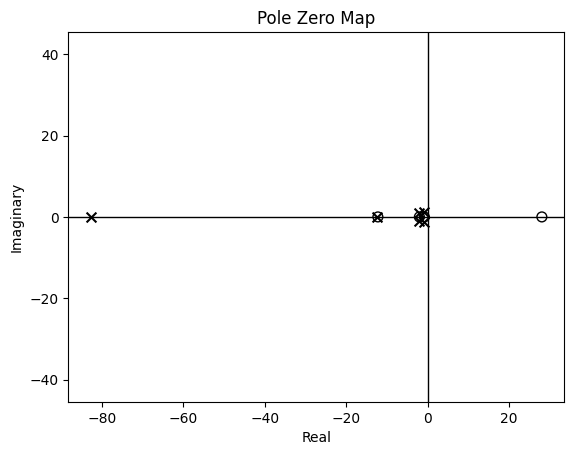

In [181]:
ct.pzmap(boat_CRO_U)

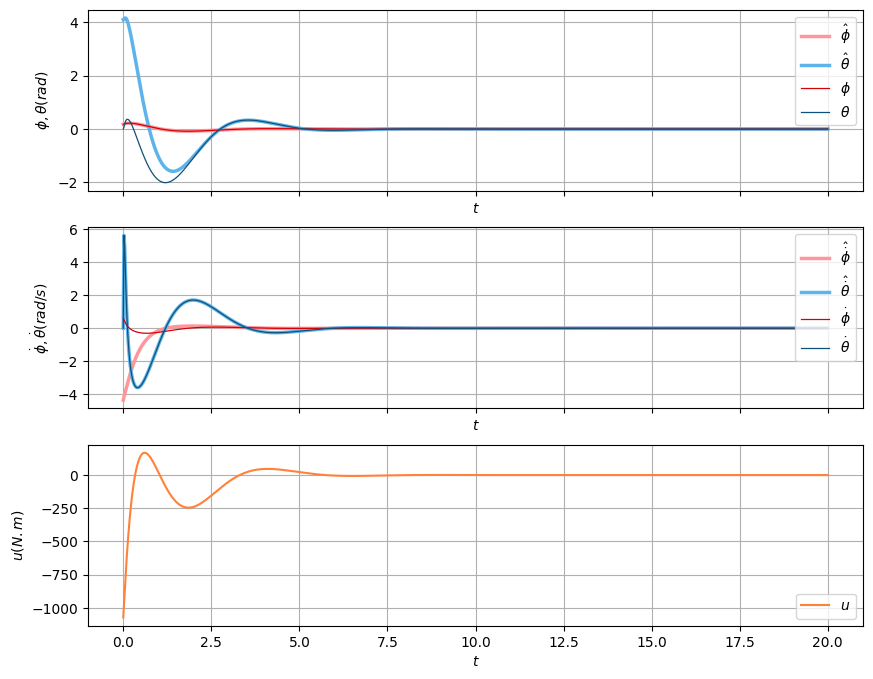

In [189]:
#Simulação Numérica:
ts = np.linspace(0, 20, 1001)
x0 = [(10.0*np.pi/180), 0.0, 0.6, 0.0, 0.5, -3.0]
t, u, x = ct.forced_response(boat_CRO_U, U=0, T=ts, X0=x0, return_x=True)
xe = S @ Cro @ x[0:n, :] + N @ x[n:, :]

fig, (angle, vel, control_input) = plt.subplots(
    3, 1, figsize=(10, 8), sharex=True)

angle.plot(t, xe[0, :], linewidth=2.5, color=cp['lred'],
           label=r'$\hat{\phi}$')
angle.plot(t, xe[1, :], linewidth=2.5, color=cp['lblue'],
           label=r'$\hat{\theta}$')
angle.plot(t, x[0, :], linewidth=0.9, color=cp['dred'], 
           label=r'$\phi$')
angle.plot(t, x[1, :], linewidth=0.9, color=cp['dblue'], 
           label=r'$\theta$')
angle.set_ylabel(r'$\phi, \theta (rad)$')
angle.set_xlabel(r'$t$')
angle.legend()
angle.grid()


vel.plot(t, xe[2, :], linewidth=2.5, color=cp['lred'],
           label=r'$\hat{\dot\phi}$')
vel.plot(t, xe[3, :], linewidth=2.5, color=cp['lblue'],
           label=r'$\hat{\dot\theta}$')
vel.plot(t, x[2, :], linewidth=0.9, color=cp['dred'], 
           label=r'$\dot\phi$')
vel.plot(t, x[3, :], linewidth=0.9, color=cp['dblue'], 
           label=r'$\dot\theta$')
vel.set_ylabel(r'$\dot\phi, \dot\theta (rad/s)$')
vel.set_xlabel(r'$t$')
vel.legend(loc = "upper right")
vel.grid()

control_input.plot(t, u, color=cp['orange'], label=r'$u$')
control_input.set_ylabel(r'$u (N.m)$')
control_input.set_xlabel(r'$t$')
control_input.legend()
control_input.grid()

Seguidor de Referência e Variáveis Exógenas:

In [190]:
#Devemos atualizar a Matriz E para ser compatível com a expressão dw(t)/dt = Aw . w(t):
Ew = np.array([[0,0],[0,0],[e_3,0],[0,0]])
Ew

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [12.39090971,  0.        ],
       [ 0.        ,  0.        ]])

In [206]:
#Matriz A_r do sinal de referência (senoidal amortecida para Phi):
ω_s = 1.000    # [rad/s]
ζ_s = 1.000   
A_r = np.array([[0, 0, 1, 0], [0, 0, 0, 1], [-ω_s ** 2, 0, -2 * ζ_s * ω_s, 0], [0, 0, 0, 0]])

#Matriz A_w das variáveis exógenas (perturbações)
A_w = np.array([[0, wf_base],[-wf_base, 0]])

A_r


array([[ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.],
       [-1.,  0., -2.,  0.],
       [ 0.,  0.,  0.,  0.]])

In [207]:
#Como dispomos de apenas um atuador, escolheremos seguir a referência apenas para uma variável de estado:
M = np.array([[0,1,0,0]])

#Inversa da matriz de estados em MF
A_cl_inv = np.linalg.inv(An(8000*np.pi/30) - Bn() @ K_lq)

#Ganho de pré-alimentação
N = np.linalg.inv(M @ A_cl_inv @ Bn()) @ M @ A_cl_inv
#F = np.block([[An(8000*np.pi/30) - A_r, Ew]])
G = N @ (An(8000*np.pi/30) - A_r)
G

array([[-3403.62298918,  -500.        ,  5484.29157101,  -394.97483024]])

In [208]:
#Matrizes do sistema estendido em malha fechada:
A_ex_cl = np.block([[An(8000*np.pi/30) - Bn() @ G, Bn() @ (K_lq - G)], 
                    [A_r - An(8000*np.pi/30) + B @ G, A_r - Bn() @ (K_lq - G)]])
E_ex_cl = np.block([[(np.eye(4) - Bn()@N)@Ew], [-(np.eye(4) - Bn()@N)@Ew]])
#np.zeros((n,2))
K_ex = np.block([[-G, K_lq - G]])

#Forma de espaço de estados
boat_ex_cl_SS = ct.ss(A_ex_cl, E_ex_cl, K_ex, 0)
boat_ex_cl_SS

<LinearIOSystem:sys[44]:['u[0]', 'u[1]']->['y[0]']>

"\ncontrol_input.plot(t, u, color=cp['orange'], label=r'$u$ (N.m)')\ncontrol_input.set_xlabel(r'$t$ (s)')\ncontrol_input.legend()\ncontrol_input.grid()\n"

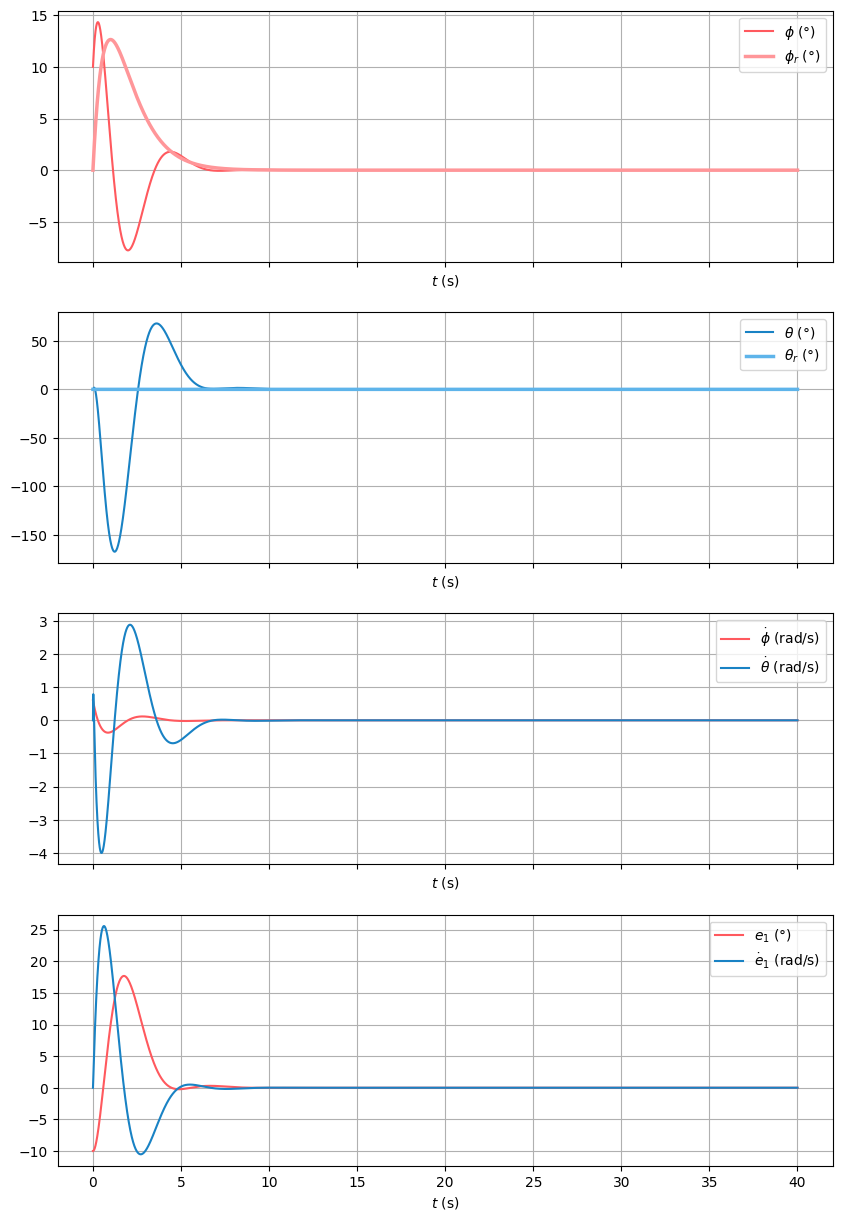

In [209]:
duration = 40 #[s]
tsteps = 20001 #n° de passos

ts = np.linspace(0, duration, tsteps)
x0 = [(10.0*np.pi/180), 0, 0.6, 0.0, 
      (-10.0*np.pi/180), 0.0, 0.0, 0.0]

t, u, x = ct.forced_response(boat_ex_cl_SS, U = 0, T=ts, X0=x0, return_x=True)
xr = x[0:4,:] + x[4:8,:]

fig, (state_roll, state_nut, state_vel, error_x) = plt.subplots(
    4, 1, figsize=(10, 15), sharex=True)

state_roll.plot(t,(180*x[0, :]/np.pi), color=cp['red'], label=r'$\phi$ (°)')
state_roll.plot(t, (180*xr[0, :]/np.pi), linewidth=2.5, color=cp['lred'], label=r'$\phi_r$ (°)')
#state_roll.plot(t, (180*x[1, :]/np.pi), color=cp['blue'], label=r'$\theta$ (°)')
#state_roll.plot(t, (180*xr[1, :]/np.pi), linewidth=2.5, color=cp['lblue'], label=r'$\theta_r$ (°)')
state_roll.set_xlabel(r'$t$ (s)')
state_roll.legend()
state_roll.grid()

state_nut.plot(t, (180*x[1, :]/np.pi), color=cp['blue'], label=r'$\theta$ (°)')
state_nut.plot(t, (180*xr[1, :]/np.pi), linewidth=2.5, color=cp['lblue'], label=r'$\theta_r$ (°)')
state_nut.set_xlabel(r'$t$ (s)')
state_nut.legend()
state_nut.grid()



state_vel.plot(t, x[2, :], color=cp['red'], label=r'$\dot\phi$ (rad/s)')
state_vel.plot(t, x[3, :], color=cp['blue'], label=r'$\dot\theta$ (rad/s)')
state_vel.set_xlabel(r'$t$ (s)')
state_vel.legend(loc = "upper right")
state_vel.grid()

error_x.plot(t, (180*x[4, :]/np.pi), color=cp['red'], label=r'$e_1$ (°)')
error_x.plot(t, (180*x[6, :]/np.pi), color=cp['blue'], label=r'$\dot e_1$ (rad/s)')
error_x.set_xlabel(r'$t$ (s)')
error_x.legend(loc = "upper right")
error_x.grid()

'''
control_input.plot(t, u, color=cp['orange'], label=r'$u$ (N.m)')
control_input.set_xlabel(r'$t$ (s)')
control_input.legend()
control_input.grid()
'''

'\nstate_nut.plot(t, (180*xs[1, :]/np.pi), color=cp[\'red\'], label=r\'$\theta$ (°)\')\nstate_nut.plot(t, (180*xp[1, :]/np.pi), linewidth=2.5, color=cp[\'blue\'], label=r\'$\theta_r$ (°)\')\nstate_nut.set_xlabel(r\'$t$ (s)\')\nstate_nut.legend()\nstate_nut.grid()\n\nstate_vel.plot(t, xs[3, :], color=cp[\'orange\'], label=r\'$\\dot\theta$ (rad/s)\')\nstate_vel.plot(t, xp[3, :], color=cp[\'turquoise\'], label=r\'$\\dot\theta$ (rad/s)\')\nstate_vel.set_xlabel(r\'$t$ (s)\')\nstate_vel.legend(loc = "upper right")\nstate_vel.grid()\n'

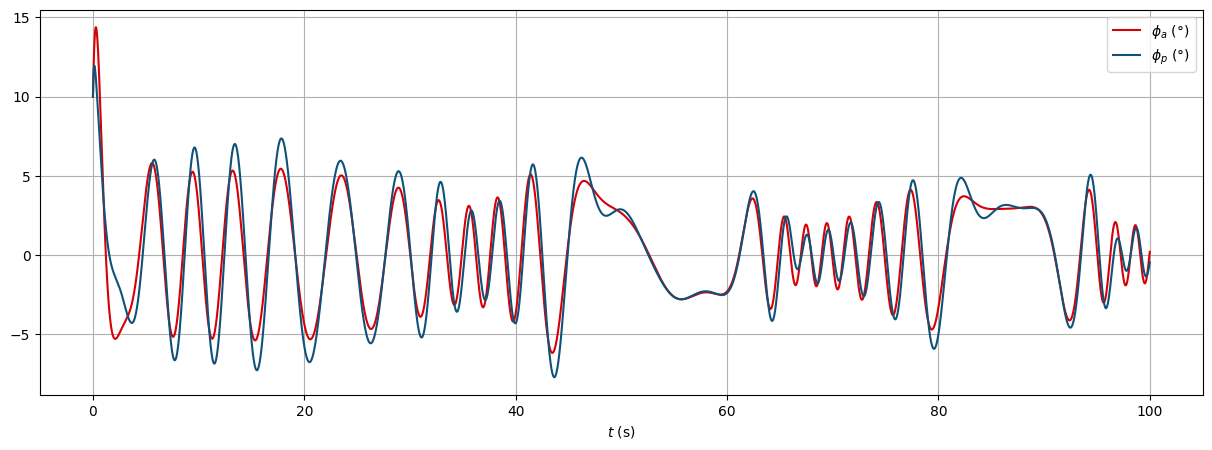

In [215]:
duration = 100 #[s]
tsteps = 40001 #n° de passos

ts = np.linspace(0, duration, tsteps)
x0 = [(10.0*np.pi/180), 0, 0.6, 0.0, 
      (5.0*np.pi/180), 0.0, 0.0, 0.0]
# x0 = [0.0, 0.3, 0.0, 0.0,
#       0.0, 0.0, 1.0, 0.0]
#aphm0*np.sin(wf*t)

#Perlin Noise functions:
noise_wf = PerlinNoise(octaves=4)
noise_A0 = PerlinNoise(octaves=8)

# Generate smooth variations in wf and A0 over time
wf_variation = np.array([wf_base + noise_wf([t / duration]) for t in ts])
A0_variation = np.array([A0_base + noise_A0([t / duration]) for t in ts])

# Interpolate the variations to match the time steps
interp_wf = interp1d(ts, wf_variation, kind='cubic')
interp_A0 = interp1d(ts, A0_variation, kind='cubic')

# Calculate wave excitation with smoothed variations
lda = g * 2 * np.pi / interp_wf(ts)
aphm0 = interp_A0(ts) / lda
Ptb = (aphm0 * np.sin(interp_wf(ts) * ts)).T
w = np.block([[Ptb],[np.zeros((1,tsteps))]])


t, u, xs = ct.forced_response(boat_ex_cl_SS, U = w, T=ts, X0=x0, return_x=True)
t, y, xp = ct.forced_response(mod_boat_passive, U = Ptb, T=ts, X0=x0[:4], return_x=True)
xr = xs[0:4,:] + xs[4:8,:]

fig, (state_roll) = plt.subplots(
    1, 1, figsize=(15, 5), sharex=True)

state_roll.plot(t,(180*xs[0, :]/np.pi), color=cp['dred'], label=r'$\phi_a$ (°)')
state_roll.plot(t,(180*xp[0, :]/np.pi), color=cp['dblue'], label=r'$\phi_p$ (°)')
state_roll.set_xlabel(r'$t$ (s)')
state_roll.legend()
state_roll.grid()

'''
state_nut.plot(t, (180*xs[1, :]/np.pi), color=cp['red'], label=r'$\theta$ (°)')
state_nut.plot(t, (180*xp[1, :]/np.pi), linewidth=2.5, color=cp['blue'], label=r'$\theta_r$ (°)')
state_nut.set_xlabel(r'$t$ (s)')
state_nut.legend()
state_nut.grid()

state_vel.plot(t, xs[3, :], color=cp['orange'], label=r'$\dot\theta$ (rad/s)')
state_vel.plot(t, xp[3, :], color=cp['turquoise'], label=r'$\dot\theta$ (rad/s)')
state_vel.set_xlabel(r'$t$ (s)')
state_vel.legend(loc = "upper right")
state_vel.grid()
'''